In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

import pandas as pd

df = pd.read_parquet('/content/drive/MyDrive/DS4A_dataset/credit_card_data_da.parquet', engine='pyarrow')
df.to_csv('credit_card_data_da.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6877837 entries, 0 to 6877836
Data columns (total 63 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   User                              int64         
 1   Card                              int64         
 2   Year                              int64         
 3   Month                             int64         
 4   Day                               int64         
 5   Time                              object        
 6   Amount                            float64       
 7   Use Chip                          object        
 8   Merchant Name                     int64         
 9   Merchant City                     object        
 10  Merchant State                    object        
 11  Zip                               float64       
 12  MCC                               int64         
 13  Errors?                           object        
 14  Is Fraud?         

In [6]:
df.head(10)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,Acct Open Date,Year PIN last Changed,Card on Dark Web,level_2,rolling_charge_off,rolling_fraud_count,rolling_tran_count,rolling_tran_volume,transaction_count,years_since_pin_change
0,0,0,2016,1,3,10:48,66.48,Chip Transaction,-3345936507911876459,La Verne,...,09/2002,2008,No,0,NaN,NaN,NaN,NaN,NaN,8
1,0,0,2016,1,4,06:43,40.02,Chip Transaction,-34551508091458520,La Verne,...,09/2002,2008,No,1,0.0,0.0,66.48,66.48,1.0,8
2,0,0,2016,1,7,09:30,54.11,Chip Transaction,4055257078481058705,La Verne,...,09/2002,2008,No,2,0.0,0.0,106.50,106.50,2.0,8
3,0,0,2016,1,7,16:03,89.48,Chip Transaction,3414527459579106770,Monterey Park,...,09/2002,2008,No,2,0.0,0.0,106.50,106.50,2.0,8
4,0,0,2016,1,10,06:38,29.15,Chip Transaction,-5475680618560174533,Monterey Park,...,09/2002,2008,No,3,0.0,0.0,250.09,250.09,4.0,8
5,0,0,2016,1,13,06:37,120.00,Chip Transaction,-4282466774399734331,Mira Loma,...,09/2002,2008,No,4,0.0,0.0,279.24,279.24,5.0,8
6,0,0,2016,1,13,13:52,56.87,Chip Transaction,3527213246127876953,La Verne,...,09/2002,2008,No,4,0.0,0.0,279.24,279.24,5.0,8
7,0,0,2016,1,15,10:56,1.44,Chip Transaction,-7232193519160172381,La Verne,...,09/2002,2008,No,5,0.0,0.0,456.11,456.11,7.0,8
8,0,0,2016,1,18,16:57,102.90,Online Transaction,208649686760524778,ONLINE,...,09/2002,2008,No,6,0.0,0.0,457.55,457.55,8.0,8
9,0,0,2016,1,19,06:58,41.61,Chip Transaction,4060646732831064559,La Verne,...,09/2002,2008,No,7,0.0,0.0,560.45,560.45,9.0,8


In [7]:
df.isnull().sum()


User                         0
Card                         0
Year                         0
Month                        0
Day                          0
                          ... 
rolling_fraud_count       8469
rolling_tran_count        8469
rolling_tran_volume       8469
transaction_count         8469
years_since_pin_change       0
Length: 63, dtype: int64

In [8]:
df["Is Fraud?"].value_counts()

No     6869425
Yes       8412
Name: Is Fraud?, dtype: int64

In [9]:
# Subset specific columns
columns_to_select = ['Year', 'Day', 'hour', 'Amount', 'Use Chip', 'Merchant Name', 'MCC', 'Is Fraud?']
df = df[columns_to_select]

In [10]:
# Replacing values in the "Is Fraud?" column
df['Is Fraud?'] = df['Is Fraud?'].map({'No': 0, 'Yes': 1})

In [11]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.4 MB/s eta 0:00:00


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from category_encoders.binary import BinaryEncoder

In [13]:

from sklearn.preprocessing import StandardScaler
import category_encoders as ce

def clean(df):
    # Convert data type
    df['hour'] = df['hour'].astype('float')

    # Scale the "Amount" column
    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df[['Amount']])

    # Binary encoding for categorical variables
    cat_col = ['Use Chip', 'Day']
    for col in cat_col:
        if col in df.columns:
            be = ce.BinaryEncoder(drop_invariant=False)
            enc_df = pd.DataFrame(be.fit_transform(df[col]), dtype='int8')
            df = pd.concat([df, enc_df], axis=1)
            df.drop([col], axis=1, inplace=True)

    for col in df.columns:
        df[col] = df[col].astype(float)

    return df

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean, validate=False)),
], verbose=True)

df_transformed = preprocessing_pipeline.fit_transform(df)

[Pipeline] .......... (step 1 of 1) Processing cleaning, total=  15.7s


Under sampling

Due to limitation of computational capacity, I subset 40000 data with 20% of them being fraud cases in order to balance the proportion and ensure model performance.

In [14]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = df_transformed.drop(columns=['Is Fraud?'])
y = df_transformed['Is Fraud?']

# Calculate the desired number of fraud cases based on the desired proportion
desired_proportion = 0.2
total_samples = 40000
fraud_samples = int(total_samples * desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples}, random_state=1613)

# Apply random undersampling to the original dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1613)

Predictive Modeling with Random Forest

In [15]:
# Modeling with Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classifier Results:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      9608
         1.0       0.91      0.83      0.87      2392

    accuracy                           0.95     12000
   macro avg       0.94      0.91      0.92     12000
weighted avg       0.95      0.95      0.95     12000

[[9417  191]
 [ 404 1988]]


In [16]:
# Hyperparameters Tuning
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Suppress all warnings
warnings.simplefilter("ignore")

# Define the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],  # Removed 'auto' and kept 'sqrt'
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='f1_macro')

grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best estimator for predictions or further work
best_rf = grid_search.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)

print("Random Forest Classifier Results with Best Hyperparameters:")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))

Best hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Classifier Results with Best Hyperparameters:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      9608
         1.0       0.92      0.83      0.88      2392

    accuracy                           0.95     12000
   macro avg       0.94      0.91      0.92     12000
weighted avg       0.95      0.95      0.95     12000

[[9445  163]
 [ 399 1993]]


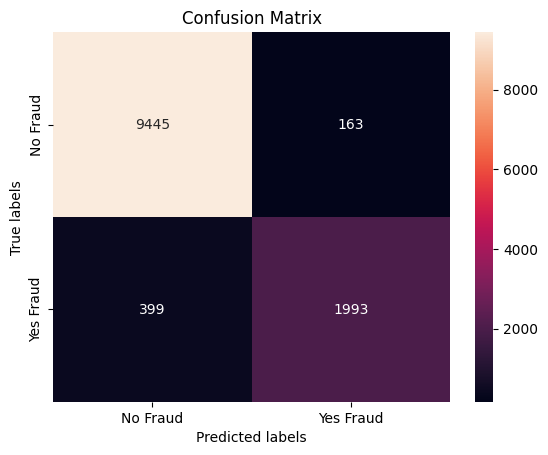

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred_best_rf), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['No Fraud', 'Yes Fraud']); ax.yaxis.set_ticklabels(['No Fraud', 'Yes Fraud']);

In [18]:
from sklearn.metrics import confusion_matrix

<Axes: >

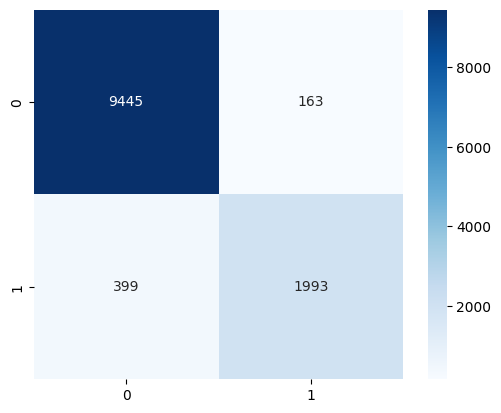

In [22]:
sns.heatmap(confusion_matrix(y_test, y_pred_best_rf), square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
#agregar labels and tittle

Interpretation:

Precision: A precision of 0.92 for class 1 means that 92% of the predicted fraud cases were actually fraudulent.

Recall: A recall of 0.83 for class 1 means that the model identified 83% of the actual fraudulent transactions.

F1-score: A F1-score of 0.88 indicates a good balance between precision and recall.

In summary, the model achieved high accuracy (95%) and performed well in classifying non-fraudulent transactions (class 0). However, it showed relatively higher recall (98%) for fraudulent transactions (class 1), indicating that it missed some fraudulent cases. Overall, the model demonstrates a good performance but could be further improved to better detect fraud cases.

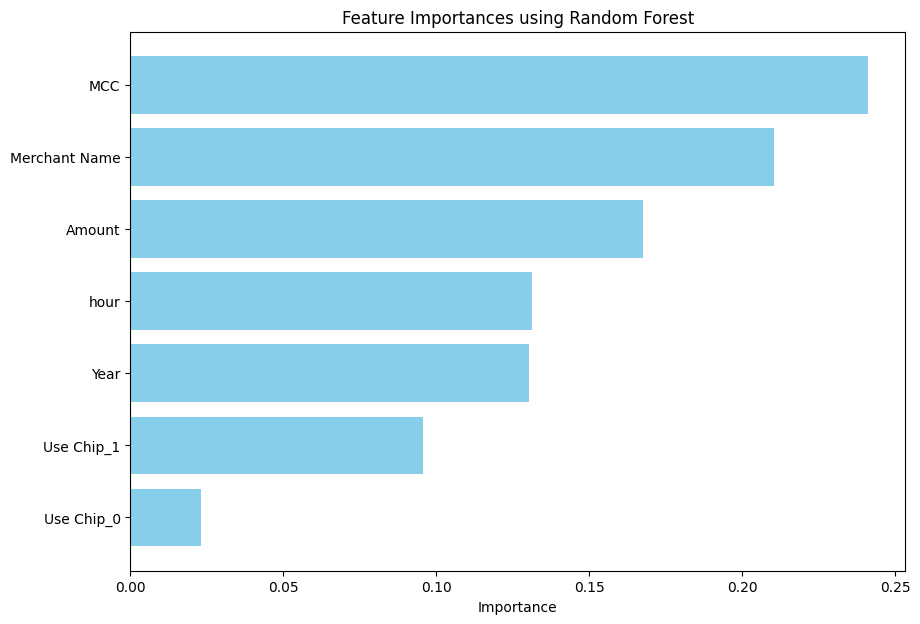

In [20]:
# Extract feature importances from the best random forest model
feature_importance = best_rf.feature_importances_
features = X_train.columns

# Sort the feature importances and their corresponding feature names
sorted_idx = feature_importance.argsort()

# Plot horizontal bar chart
plt.figure(figsize=(10, 7))
plt.barh(features[sorted_idx], feature_importance[sorted_idx], align='center', color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances using Random Forest')
plt.show()

Insights

Based on the feature importance scores, the three top most important features for predicting fraud transactions are:
1. MCC: Merchant Category Code And Merchant Name
•	Insight: Certain types of merchants or industries may be more susceptible to fraudulent activities than others. Some businesses are at a higher risk of fraud than others. This can happen because they handle a lot of transactions, sell expensive items, or offer products that are popular in the illegal market. It's important to know which businesses might be more vulnerable to fraud

3. Amount: transaction amount
•	Insight: Fraudsters often use the size of a transaction to their advantage. They might make big purchases to get as much as they can before the card is reported stolen. Alternatively, they could make small purchases to check if the card works without attracting attention. So, if you notice transactions that are much bigger or smaller than your usual spending, it's a warning sign.

Recommendations
1. For MCC and Merchant Name:
•	Businesses and credit card companies need to pay extra attention to certain types of stores that are more likely to face fraud. They should keep a close watch and put extra safety measures in place for these places. It's also a good idea to educate people about being careful when shopping in these specific areas.
2. For Amount:
•	Create a smart system that spots really high or low transactions compared to what a user usually spends. If something unusual happens, let users know about it